#Imports

In [ ]:
from datetime import datetime
from distutils.util import strtobool
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn import set_config
from sklearn.metrics import mean_squared_error
set_config(transform_output = "pandas")
from sklearn.neural_network import MLPRegressor as mlpregressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import trange

#Load Data

In [ ]:
bitcoin = pd.read_csv("/content/drive/MyDrive/CIVE7100/bitcoinData.csv", index_col = 0)
bitcoin = bitcoin[['google_trends', 'difficulty', 'active_addresses', 'price']]
bitcoin['returns'] = bitcoin['price'].astype('float64') - bitcoin['price'].astype('float64').shift(1)
bitcoin.dropna(inplace = True)
bitcoin.head()

,google_trends,difficulty,active_addresses,price,returns
2014-04-10,13.854,6.119726e+09,182996.0,407.703,-39.407
2014-04-11,12.997,6.119726e+09,169622.0,403.328,-4.375
2014-04-12,9.229,6.119726e+09,132283.0,425.310,21.982
2014-04-13,10.385,6.119726e+09,172708.0,415.876,-9.434
2014-04-14,10.754,6.119726e+09,183291.0,445.898,30.022


In [ ]:
bitcoin['logReturn'] = np.log(bitcoin['price'].astype('float64')/bitcoin['price'].astype('float64').shift(1))
bitcoin.dropna(inplace = True)
bitcoin.drop(['returns', 'price'], axis = 1, inplace = True)
bitcoin.head()

,google_trends,difficulty,active_addresses,logReturn
2014-04-11,12.997,6.119726e+09,169622.0,-0.010789
2014-04-12,9.229,6.119726e+09,132283.0,0.053068
2014-04-13,10.385,6.119726e+09,172708.0,-0.022431
2014-04-14,10.754,6.119726e+09,183291.0,0.069703
2014-04-15,11.053,6.119726e+09,199054.0,0.089541


In [ ]:
bitcoinFeatures = bitcoin.copy()
bitcoinLogReturn = bitcoin['logReturn'].copy()

#MinMax Normalization

In [ ]:
scaler = MinMaxScaler()
bitcoinFeatures = scaler.fit_transform(bitcoinFeatures.drop(['logReturn'], axis = 1))
bitcoinFeatures = pd.concat([bitcoinFeatures, bitcoinLogReturn], axis = 1)
bitcoinFeatures.head()

,google_trends,difficulty,active_addresses,logReturn
2014-04-11,0.012637,0.0,0.051984,-0.010789
2014-04-12,0.006476,0.0,0.017498,0.053068
2014-04-13,0.008367,0.0,0.054834,-0.022431
2014-04-14,0.008970,0.0,0.064609,0.069703
2014-04-15,0.009459,0.0,0.079167,0.089541


# Train Validation Test Split

In [ ]:
bitcoinFeaturesArray = np.array(bitcoinFeatures)
bitcoinLogReturnArray = np.array(bitcoinLogReturn)

trainFeatures = bitcoinFeaturesArray[:-8]
trainTargets = bitcoinLogReturnArray[1:-8 + 1]

testFeatures = bitcoinFeaturesArray[-8:-1]
testTargets = bitcoinLogReturnArray[-8 + 1:]

validSplitIndex = round(len(trainFeatures) * 0.8)

validFeatures = trainFeatures[validSplitIndex:-1]
validTargets = trainTargets[validSplitIndex + 1:]

trainFeatures = bitcoinFeaturesArray[:validSplitIndex]
trainTargets = bitcoinLogReturnArray[1:validSplitIndex + 1]

print(trainFeatures.shape)
print(trainTargets.shape)
print(validFeatures.shape)
print(validTargets.shape)
print(testFeatures.shape)
print(testTargets.shape)

(2119, 4)
(2119,)
(529, 4)
(529,)
(7, 4)
(7,)


# Set Hyperparameters

In [ ]:
# Set the hyperparameters
inputSize = bitcoinFeatures.shape[1]     # Number of features in the input (multivariate time series)
hiddenSize = 8     # Number of hidden units in the LSTM
LSTMLayers = 1      # Number of LSTM layers
outputSize = 1
numEpochs = 200
learningRate = 0.01
trainBatchSize = 64
testBatchSize = 32

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Try vanilla MLP

In [ ]:
mlp = mlpregressor(hidden_layer_sizes = (64),
                   max_iter = 500,
                   activation = 'relu',
                   batch_size = 64,
                   shuffle = False)

mlp = mlp.fit(trainFeatures, trainTargets)

In [ ]:
pred = mlp.predict(testFeatures)
pred

array([5.85086984e-03, 9.31528909e-05, 3.70497138e-03, 3.70116473e-03,
       3.05472283e-03, 4.51269337e-03, 6.57729482e-03])

In [ ]:
np.sqrt(mean_squared_error(testTargets, pred))

0.022685194906647718

#Send Data to GPU

In [ ]:
# Convert features and targets to PyTorch tensors for each
trainFeatures = torch.tensor(trainFeatures, dtype = torch.float, device = DEVICE).unsqueeze(1)
trainTargets = torch.tensor(trainTargets, dtype = torch.float, device = DEVICE).unsqueeze(1)

validFeatures = torch.tensor(validFeatures, dtype = torch.float, device = DEVICE).unsqueeze(1)
validTargets = torch.tensor(validTargets, dtype = torch.float, device = DEVICE).unsqueeze(1)

testFeatures = torch.tensor(testFeatures, dtype = torch.float, device = DEVICE).unsqueeze(1)
testTargets = torch.tensor(testTargets, dtype = torch.float, device = DEVICE).unsqueeze(1)

In [ ]:
# Create a DataLoader for each
trainDataset = TensorDataset(trainFeatures, trainTargets)
train_loader = DataLoader(trainDataset, batch_size = trainBatchSize, shuffle = True)

validDataset = TensorDataset(validFeatures, validTargets)
valid_loader = DataLoader(validDataset, batch_size = trainBatchSize, shuffle = True)

testDataset = TensorDataset(testFeatures, testTargets)
test_loader = DataLoader(testDataset, batch_size = testBatchSize, shuffle = False)

# LSTM functions

In [ ]:
# Define the multivariate LSTM model for time series forecasting
class LSTMTimeSeries(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(LSTMTimeSeries, self).__init__()

    # Define the LSTM layer
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional = False)

    # Define the output layer
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out, (hn, cn) = self.lstm(x)

    # Index into the final time step output
    out = out[:, -1, :]

    out = self.fc(out)

    return out

In [ ]:
# Train 1 epoch function
def train_one_epoch(train_loader, model, device, optimizer):

    model.train()
    trainLoss = 0

    for sequences, targets in train_loader:

      # Forward pass
      outputs = model(sequences)#.reshape(-1)
      trainLoss = torch.sqrt(criterion(outputs, targets))

      # Backpropagation and optimization
      optimizer.zero_grad()
      trainLoss.backward()
      optimizer.step()

    return float(trainLoss.detach().cpu().numpy())

In [ ]:
# Test 1 epoch function
def test_one_epoch(test_loader, model, device):

  model.eval()
  testLoss = 0

  with torch.no_grad():

    for sequences, targets in test_loader:

      # predict with model
      outputs = model(sequences)#.reshape(-1)
      testLoss = torch.sqrt(criterion(outputs, targets))

  return float(testLoss.detach().cpu().numpy())

#Instantiate Model and Parameters

In [ ]:
# Create the model
LSTMModel = LSTMTimeSeries(inputSize, hiddenSize, LSTMLayers, outputSize).to(DEVICE)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(LSTMModel.parameters(), lr = learningRate)

print(LSTMModel)
print("Trainable Parameters:", sum(p.numel() for p in LSTMModel.parameters() if p.requires_grad))

LSTMTimeSeries(
  (lstm): LSTM(4, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)
Trainable Parameters: 457


#Train LSTM

In [ ]:
train_losses = []
val_losses = []

for epoch in trange(numEpochs, leave = True, desc = 'Epochs'):

  train_epoch = train_one_epoch(train_loader, LSTMModel, DEVICE, optimizer)
  train_loss = train_epoch
  print("\nTrain Loss ", epoch, "RMSE: ", train_loss)

  val_epoch = test_one_epoch(valid_loader, LSTMModel, DEVICE)
  val_loss = val_epoch
  print("Validation Loss ", epoch, "RMSE: ", val_loss)

  # Record results
  train_losses.append(train_loss)
  val_losses.append(val_loss)

Epochs:   1%|          | 2/200 [00:00<00:17, 11.40it/s]


Train Loss  0 RMSE:  0.019541852176189423
Validation Loss  0 RMSE:  0.027955008670687675

Train Loss  1 RMSE:  0.017169099301099777
Validation Loss  1 RMSE:  0.02366703934967518

Train Loss  2 RMSE:  0.02379676327109337
Validation Loss  2 RMSE:  0.04572915658354759


Epochs:   2%|▏         | 4/200 [00:00<00:16, 11.60it/s]


Train Loss  3 RMSE:  0.018120238557457924
Validation Loss  3 RMSE:  0.019607773050665855

Train Loss  4 RMSE:  0.024230802431702614
Validation Loss  4 RMSE:  0.030455725267529488

Train Loss  5 RMSE:  0.02404555305838585


Epochs:   4%|▍         | 8/200 [00:00<00:17, 10.89it/s]

Validation Loss  5 RMSE:  0.06348098069429398

Train Loss  6 RMSE:  0.04147619009017944
Validation Loss  6 RMSE:  0.039916954934597015

Train Loss  7 RMSE:  0.03061285987496376
Validation Loss  7 RMSE:  0.030571792274713516


Epochs:   5%|▌         | 10/200 [00:00<00:17, 10.73it/s]


Train Loss  8 RMSE:  0.015560072846710682
Validation Loss  8 RMSE:  0.031623475253582

Train Loss  9 RMSE:  0.018448371440172195
Validation Loss  9 RMSE:  0.02382700890302658

Train Loss  10 RMSE:  0.025857137516140938


Epochs:   6%|▌         | 12/200 [00:01<00:17, 10.70it/s]

Validation Loss  10 RMSE:  0.02844827249646187

Train Loss  11 RMSE:  0.03541441634297371
Validation Loss  11 RMSE:  0.034690357744693756

Train Loss  12 RMSE:  0.0394928976893425
Validation Loss  12 RMSE:  0.06348639726638794


Epochs:   8%|▊         | 16/200 [00:01<00:16, 10.96it/s]


Train Loss  13 RMSE:  0.02863747999072075
Validation Loss  13 RMSE:  0.027620181441307068

Train Loss  14 RMSE:  0.016430217772722244
Validation Loss  14 RMSE:  0.03480159491300583

Train Loss  15 RMSE:  0.022408168762922287
Validation Loss  15 RMSE:  0.05671369656920433


Epochs:   9%|▉         | 18/200 [00:01<00:16, 10.87it/s]


Train Loss  16 RMSE:  0.04224814102053642
Validation Loss  16 RMSE:  0.023173216730356216

Train Loss  17 RMSE:  0.023010870441794395
Validation Loss  17 RMSE:  0.02368045784533024

Train Loss  18 RMSE:  0.03289415314793587
Validation Loss  18 RMSE:  0.03253887593746185


Epochs:  11%|█         | 22/200 [00:02<00:16, 10.96it/s]


Train Loss  19 RMSE:  0.018696023151278496
Validation Loss  19 RMSE:  0.03578738123178482

Train Loss  20 RMSE:  0.021193139255046844
Validation Loss  20 RMSE:  0.06371331959962845

Train Loss  21 RMSE:  0.03200315684080124
Validation Loss  21 RMSE:  0.03901727870106697


Epochs:  12%|█▏        | 24/200 [00:02<00:16, 11.00it/s]


Train Loss  22 RMSE:  0.018873855471611023
Validation Loss  22 RMSE:  0.035270679742097855

Train Loss  23 RMSE:  0.021737009286880493
Validation Loss  23 RMSE:  0.03976735845208168

Train Loss  24 RMSE:  0.01904088631272316
Validation Loss  24 RMSE:  0.012750055640935898


Epochs:  13%|█▎        | 26/200 [00:02<00:15, 11.14it/s]


Train Loss  25 RMSE:  0.03154424950480461
Validation Loss  25 RMSE:  0.04729409143328667

Train Loss  26 RMSE:  0.022975532338023186
Validation Loss  26 RMSE:  0.031046345829963684

Train Loss  27 RMSE:  0.018543265759944916
Validation Loss 

Epochs:  14%|█▍        | 28/200 [00:02<00:15, 10.86it/s]

 27 RMSE:  0.027991805225610733

Train Loss  28 RMSE:  0.013920621946454048
Validation Loss  28 RMSE:  0.03720119595527649


Epochs:  15%|█▌        | 30/200 [00:02<00:17,  9.97it/s]


Train Loss  29 RMSE:  0.026086075231432915
Validation Loss  29 RMSE:  0.0265743900090456

Train Loss  30 RMSE:  0.00977377686649561
Validation Loss  30 RMSE:  0.032801661640405655


Epochs:  16%|█▋        | 33/200 [00:03<00:18,  9.15it/s]


Train Loss  31 RMSE:  0.008815309032797813
Validation Loss  31 RMSE:  0.03230803832411766

Train Loss  32 RMSE:  0.03792733699083328
Validation Loss  32 RMSE:  0.04410691186785698


Epochs:  18%|█▊        | 35/200 [00:03<00:18,  9.00it/s]


Train Loss  33 RMSE:  0.02481786347925663
Validation Loss  33 RMSE:  0.03707379475235939

Train Loss  34 RMSE:  0.013530440628528595
Validation Loss  34 RMSE:  0.02515706792473793


Epochs:  18%|█▊        | 37/200 [00:03<00:18,  8.59it/s]


Train Loss  35 RMSE:  0.04291243851184845
Validation Loss  35 RMSE:  0.04210418462753296

Train Loss  36 RMSE:  0.03638726472854614
Validation Loss  36 RMSE:  0.04554501175880432


Epochs:  20%|█▉        | 39/200 [00:03<00:18,  8.53it/s]


Train Loss  37 RMSE:  0.01645348034799099
Validation Loss  37 RMSE:  0.031182823702692986

Train Loss  38 RMSE:  0.029165636748075485
Validation Loss  38 RMSE:  0.030051682144403458


Epochs:  20%|██        | 41/200 [00:04<00:18,  8.40it/s]


Train Loss  39 RMSE:  0.0188762117177248
Validation Loss  39 RMSE:  0.030248206108808517

Train Loss  40 RMSE:  0.03334430605173111
Validation Loss  40 RMSE:  0.03573895990848541


Epochs:  22%|██▏       | 43/200 [00:04<00:19,  8.12it/s]


Train Loss  41 RMSE:  0.019207267090678215
Validation Loss  41 RMSE:  0.03513554111123085

Train Loss  42 RMSE:  0.03496432304382324
Validation Loss  42 RMSE:  0.038987163454294205


Epochs:  22%|██▎       | 45/200 [00:04<00:18,  8.21it/s]


Train Loss  43 RMSE:  0.05146012455224991
Validation Loss  43 RMSE:  0.02817702479660511

Train Loss  44 RMSE:  0.017193954437971115
Validation Loss  44 RMSE:  0.025712504982948303


Epochs:  24%|██▎       | 47/200 [00:04<00:18,  8.20it/s]


Train Loss  45 RMSE:  0.04167117923498154
Validation Loss  45 RMSE:  0.03635795786976814

Train Loss  46 RMSE:  0.04059608280658722
Validation Loss  46 RMSE:  0.02476675994694233


Epochs:  24%|██▍       | 49/200 [00:05<00:18,  8.04it/s]


Train Loss  47 RMSE:  0.03152824565768242
Validation Loss  47 RMSE:  0.03740212693810463

Train Loss  48 RMSE:  0.014213567599654198
Validation Loss  48 RMSE:  0.06905034929513931


Epochs:  26%|██▌       | 51/200 [00:05<00:18,  8.14it/s]


Train Loss  49 RMSE:  0.01729252189397812
Validation Loss  49 RMSE:  0.027617482468485832

Train Loss  50 RMSE:  0.01856723614037037
Validation Loss  50 RMSE:  0.028542961925268173


Epochs:  26%|██▋       | 53/200 [00:05<00:17,  8.26it/s]


Train Loss  51 RMSE:  0.04381410777568817
Validation Loss  51 RMSE:  0.038983218371868134

Train Loss  52 RMSE:  0.01745019108057022
Validation Loss  52 RMSE:  0.03379791975021362


Epochs:  28%|██▊       | 55/200 [00:05<00:17,  8.39it/s]


Train Loss  53 RMSE:  0.011491728946566582
Validation Loss  53 RMSE:  0.02356407791376114

Train Loss  54 RMSE:  0.010972145944833755
Validation Loss  54 RMSE:  0.017214851453900337


Epochs:  28%|██▊       | 57/200 [00:06<00:17,  8.40it/s]


Train Loss  55 RMSE:  0.019038591533899307
Validation Loss  55 RMSE:  0.04395851120352745

Train Loss  56 RMSE:  0.0519038662314415
Validation Loss  56 RMSE:  0.021922463551163673


Epochs:  30%|██▉       | 59/200 [00:06<00:16,  8.66it/s]


Train Loss  57 RMSE:  0.019173968583345413
Validation Loss  57 RMSE:  0.035772696137428284

Train Loss  58 RMSE:  0.018501685932278633
Validation Loss  58 RMSE:  0.015568193979561329


Epochs:  30%|███       | 61/200 [00:06<00:16,  8.52it/s]


Train Loss  59 RMSE:  0.010395902208983898
Validation Loss  59 RMSE:  0.04015828296542168

Train Loss  60 RMSE:  0.03321464732289314
Validation Loss  60 RMSE:  0.026234466582536697


Epochs:  32%|███▏      | 63/200 [00:06<00:16,  8.29it/s]


Train Loss  61 RMSE:  0.03345527499914169
Validation Loss  61 RMSE:  0.02615995518863201

Train Loss  62 RMSE:  0.01793311908841133
Validation Loss  62 RMSE:  0.026784339919686317


Epochs:  32%|███▎      | 65/200 [00:07<00:16,  8.35it/s]


Train Loss  63 RMSE:  0.022371169179677963
Validation Loss  63 RMSE:  0.022925101220607758

Train Loss  64 RMSE:  0.01906832680106163
Validation Loss  64 RMSE:  0.03171292319893837


Epochs:  34%|███▎      | 67/200 [00:07<00:15,  8.53it/s]


Train Loss  65 RMSE:  0.04427046701312065
Validation Loss  65 RMSE:  0.02910308726131916

Train Loss  66 RMSE:  0.02425847388803959
Validation Loss  66 RMSE:  0.034463897347450256


Epochs:  34%|███▍      | 69/200 [00:07<00:15,  8.58it/s]


Train Loss  67 RMSE:  0.03224104642868042
Validation Loss  67 RMSE:  0.04510875418782234

Train Loss  68 RMSE:  0.014108284376561642
Validation Loss  68 RMSE:  0.043249912559986115


Epochs:  36%|███▌      | 71/200 [00:07<00:15,  8.30it/s]


Train Loss  69 RMSE:  0.0405271090567112
Validation Loss  69 RMSE:  0.03382551670074463

Train Loss  70 RMSE:  0.027649909257888794
Validation Loss  70 RMSE:  0.06436502933502197


Epochs:  36%|███▋      | 73/200 [00:07<00:15,  8.44it/s]


Train Loss  71 RMSE:  0.014523988589644432
Validation Loss  71 RMSE:  0.028716176748275757

Train Loss  72 RMSE:  0.028657834976911545
Validation Loss  72 RMSE:  0.03805215284228325


Epochs:  38%|███▊      | 75/200 [00:08<00:14,  8.36it/s]


Train Loss  73 RMSE:  0.014893611893057823
Validation Loss  73 RMSE:  0.038721714168787

Train Loss  74 RMSE:  0.010824966244399548
Validation Loss  74 RMSE:  0.03141118586063385


Epochs:  38%|███▊      | 75/200 [00:08<00:13,  9.03it/s]


Train Loss  75 RMSE:  0.034434109926223755


KeyboardInterrupt: ignored

#Visualize Training Results

Text(0.5, 1.0, '1 Layer LSTM Training Curve\nfor Forecasting Bitcoin Prices')

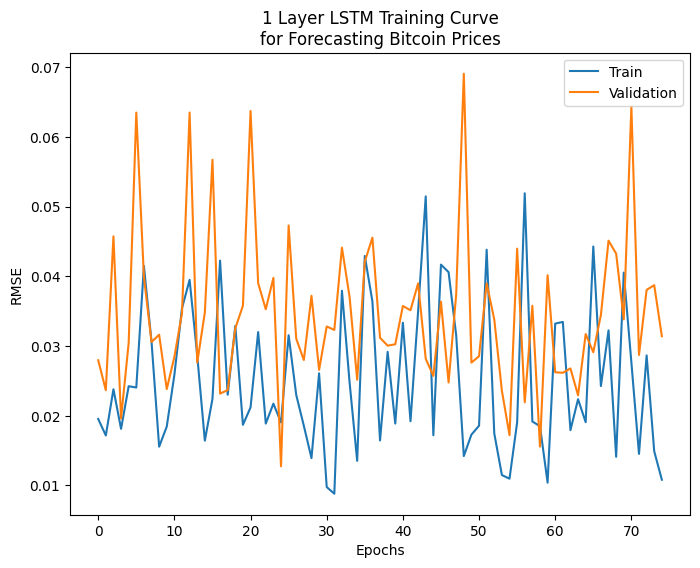

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(train_losses, label = 'Train')
plt.plot(val_losses, label = 'Validation')
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Epochs")
plt.title("1 Layer LSTM Training Curve\nfor Forecasting Bitcoin Prices")

#Eval on Test Data

In [ ]:
test_one_epoch(test_loader, LSTMModel, DEVICE)

0.018761243671178818